fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0.]
fixed m: [1. 0

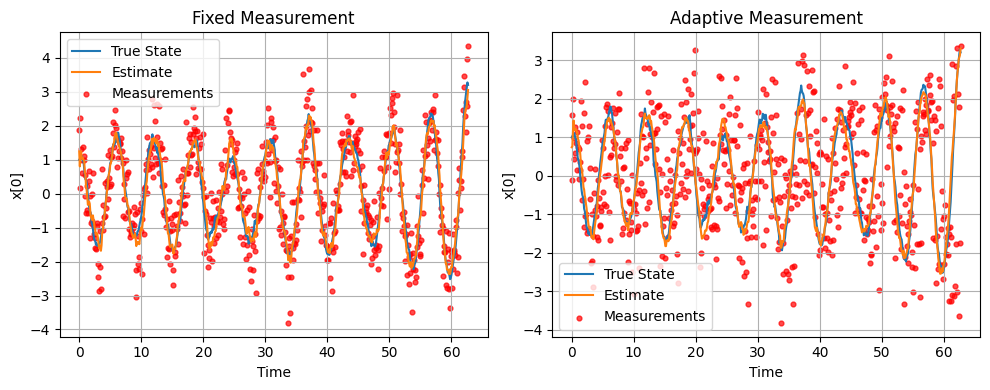

In [2]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Generate the "true" system trajectory + measurement noise
# ------------------------------------------------------------

def generate_data(periods=6, dt=0.1, omega=1.0, Q_scale=0.005, R_val=0.5, seed=42):
    """
    Generates:
      - x_true: shape (time_steps, 2), the "true" states of the system
                with process noise added at each step
      - A:      2x2 matrix = expm(A_euler)
      - Q:      2x2 process noise covariance
      - R_val:  scalar measurement noise variance
      - measurement_noises: shape (time_steps,), one noise sample per step

    The idea is to keep the same x_true and measurement_noises for
    both fixed and adaptive filters, so they see the *exact same* random draws.
    """
    np.random.seed(seed)  # reproducible
    
    # 1) Define system matrix A
    A_euler = np.array([[0, dt],
                        [-omega**2 * dt, 0]])
    A = scipy.linalg.expm(A_euler)  # discrete-time transition
    Q = np.eye(2) * Q_scale * dt    # process noise covariance
    
    # 2) Number of time steps
    time_steps = round(periods * 2 * np.pi / dt)
    
    # 3) Generate "true" states with process noise
    x_true = np.zeros((time_steps, 2))
    x_true[0] = [1.0, 0.0]  # initial condition
    for k in range(time_steps - 1):
        w_k = np.random.multivariate_normal([0, 0], Q)
        x_true[k+1] = A @ x_true[k] + w_k
    
    # 4) Generate measurement noises (one per step)
    #    We'll reuse these for *both* filters.
    measurement_noises = np.random.normal(0, np.sqrt(R_val), size=time_steps)
    
    return x_true, A, Q, R_val, measurement_noises, dt

# ------------------------------------------------------------
# 2. Kalman Predict/Update + principal eigenvector
# ------------------------------------------------------------

def kalman_predict(x_est, P_est, A, Q):
    x_pred = A @ x_est
    P_pred = A @ P_est @ A.T + Q
    return x_pred, P_pred

def kalman_update(x_pred, P_pred, y, m, R):
    y_pred = m @ x_pred
    innovation = y - y_pred
    S = m @ P_pred @ m + R  # scalar
    K = (P_pred @ m) / S    # shape (2,)
    x_est = x_pred + K * innovation
    P_est = P_pred - np.outer(K, m) @ P_pred
    return x_est, P_est

def principal_eigenvector(P):
    vals, vecs = np.linalg.eig(P)
    idx = np.argmax(vals)
    v = vecs[:, idx]
    return v / np.linalg.norm(v)

# ------------------------------------------------------------
# 3. Run Kalman: Fixed vs. Adaptive, reusing same data
# ------------------------------------------------------------

def run_kalman_fixed(x_true, A, Q, R_val, measurement_noises):
    """
    Uses m = [1, 0] at each step, reusing the same measurement_noises
    so that measurement_noises[k] is the random part of y_k.
    """
    time_steps = x_true.shape[0]
    x_est = np.array([0.0, 0.0])
    P_est = np.eye(2) * 1.0
    
    x_est_array = np.zeros((time_steps, 2))
    measurements = np.zeros(time_steps)
    
    for k in range(time_steps):
        # Predict
        x_pred, P_pred = kalman_predict(x_est, P_est, A, Q)
        
        # True state at step k
        xk_true = x_true[k]
        
        # Generate measurement: same noise draw, but direction = [1,0]
        m = np.array([1.0, 0.0])
        print(f"fixed m: {m}")
        y = m @ xk_true + measurement_noises[k]
        
        # Update
        x_est, P_est = kalman_update(x_pred, P_pred, y, m, R_val)
        
        x_est_array[k] = x_est
        measurements[k] = y
    
    return x_est_array, measurements

def run_kalman_adaptive(x_true, A, Q, R_val, measurement_noises):
    """
    Uses m = principal_eigenvector(P_pred) each step, reusing the same
    measurement_noises.  So measurement_noises[k] is the random part of y_k.
    """
    time_steps = x_true.shape[0]
    x_est = np.array([0.0, 0.0])
    P_est = np.eye(2) * 1.0
    
    x_est_array = np.zeros((time_steps, 2))
    measurements = np.zeros(time_steps)
    
    for k in range(time_steps):
        # Predict
        x_pred, P_pred = kalman_predict(x_est, P_est, A, Q)
        
        # True state at step k
        xk_true = x_true[k]
        
        # Adaptive measurement direction
        m = principal_eigenvector(P_pred)
        print(f"adaptive m: {m}")
        
        # Generate measurement using the *same* noise draw as the fixed approach
        y = m @ xk_true + measurement_noises[k]
        
        # Update
        x_est, P_est = kalman_update(x_pred, P_pred, y, m, R_val)
        
        x_est_array[k] = x_est
        measurements[k] = y
    
    return x_est_array, measurements

# ------------------------------------------------------------
# 4. Main: Generate data once, run both filters, compare
# ------------------------------------------------------------

def main():
    # 1) Generate system + data
    #    We'll fix the random seed so both methods see the same process noise
    #    and the same measurement noise draws (just used differently).
    x_true, A, Q, R_val, measurement_noises, dt = generate_data(
        periods=10, dt=0.1, omega=1.0, Q_scale=0.05, R_val=0.5, seed=42
    )
    
    time_steps = x_true.shape[0]
    time_array = np.arange(time_steps) * dt
    
    # 2) Run Kalman with fixed measurement
    x_est_fixed, meas_fixed = run_kalman_fixed(x_true, A, Q, R_val, measurement_noises)
    
    # 3) Run Kalman with adaptive measurement
    x_est_adaptive, meas_adaptive = run_kalman_adaptive(x_true, A, Q, R_val, measurement_noises)


 
    
    # 4) Plot
    plt.figure(figsize=(10,4))
    
    # Left: Fixed
    plt.subplot(1,2,1)
    plt.plot(time_array, x_true[:,0], label="True State")
    plt.plot(time_array, x_est_fixed[:,0], label="Estimate")
    plt.scatter(time_array, meas_fixed, s=12, color='r', alpha=0.7, label="Measurements")
    plt.title("Fixed Measurement")
    plt.xlabel("Time")
    plt.ylabel("x[0]")
    plt.grid(True)
    plt.legend()
    
    # Right: Adaptive
    plt.subplot(1,2,2)
    plt.plot(time_array, x_true[:,0], label="True State")
    plt.plot(time_array, x_est_adaptive[:,0], label="Estimate")
    plt.scatter(time_array, meas_adaptive, s=12, color='r', alpha=0.7, label="Measurements")
    plt.title("Adaptive Measurement")
    plt.xlabel("Time")
    plt.ylabel("x[0]")
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


### Markdown

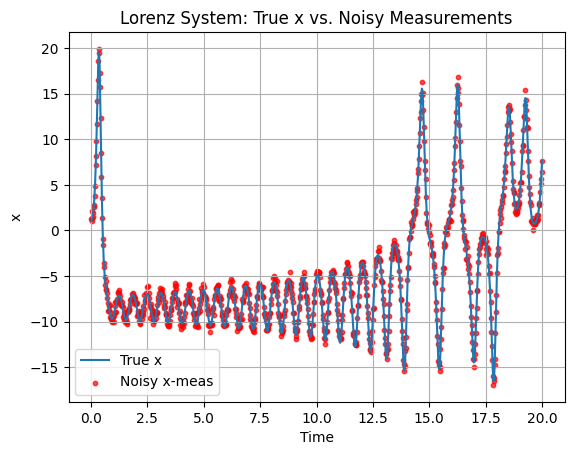

In [1]:
import numpy as np
import scipy.linalg
from scipy.integrate import solve_ivp

def generate_lorenz_data(sigma=10.0, rho=28.0, beta=8/3,
                         dt=0.02, t_end=20.0, x0=[1.0, 1.0, 1.0],
                         R_val=0.2, seed=42):
    """
    Generates a Lorenz trajectory by numerically integrating the ODE,
    then adds measurement noise for observations of (x, y).

    :param sigma, rho, beta: Lorenz system parameters.
    :param dt: time step for the solver output.
    :param t_end: end time.
    :param x0: initial condition [x, y, z].
    :param R_val: measurement noise variance for each of x, y.
    :param seed: random seed for reproducibility.

    :return:
      time_span: array of time points of length N.
      true_states: shape (N, 3), the solution of the Lorenz system [x, y, z].
      measurements: shape (N, 2), noisy measurements of [x, y].
    """
    np.random.seed(seed)

    # Define the Lorenz system
    def lorenz_system(t, state):
        x, y, z = state
        dxdt = sigma * (y - x)
        dydt = x * (rho - z) - y
        dzdt = x * y - beta * z
        return [dxdt, dydt, dzdt]

    # Build the time array and solve the ODE
    N = round(t_end / dt)
    time_span = np.linspace(0, t_end, N)
    sol = solve_ivp(lorenz_system, [time_span[0], time_span[-1]], x0, t_eval=time_span)

    # True states: shape (N, 3) after transposing sol.y (which is (3, N))
    true_states = sol.y.T

    # Measurement noise covariance R (2x2). We measure (x, y) only.
    R = np.eye(2) * R_val

    # Generate measurement noise. We draw N samples from N(0, R).
    # shape: (N,2). Then we multiply by sqrtm(R).T for correlated if needed.
    noise = np.random.normal(0, 1, (N, 2)) @ scipy.linalg.sqrtm(R).T

    # Observations: H = [[1, 0, 0],
    #                    [0, 1, 0]]
    # so we take (x, y) from the true states and add noise
    measurements = true_states[:, :2] + noise

    return time_span, true_states, measurements


# ------------------------------------------------------

# Generate Lorenz data
t_array, X_true, Y_meas = generate_lorenz_data(
    sigma=10, rho=28, beta=8/3,
    dt=0.02, t_end=20,
    x0=[1,1,1],
    R_val=0.2,
    seed=42
)

# Plot the first coordinate (x) vs. time
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t_array, X_true[:,0], label='True x')
plt.scatter(t_array, Y_meas[:,0], s=10, color='r', alpha=0.7, label='Noisy x-meas')
plt.title("Lorenz System: True x vs. Noisy Measurements")
plt.xlabel("Time")
plt.ylabel("x")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

def lorenz_jacobian(x_est, sigma=10, rho=28, beta=8/3):
    """Compute the Jacobian matrix for the Lorenz system at state x"""
    # Extract state variables as float values
    x1 = x_est[0]
    x2 = x_est[1]
    x3 = x_est[2]
    
    # Construct Jacobian with proper float dtype
    J = np.array([
        [-sigma, sigma, 0], 
        [rho - x3, -1, -x1],
        [x2, x1, -beta]
    ], dtype=float)
    
    return J


def kalman_update_lorenz(x, P, y, sigma2):
    """
    Perform the Kalman update step with adaptive measurement direction.
    
    Args:
        x: State estimate (3x1 vector)
        P: State covariance matrix (3x3 matrix)
        y: Scalar measurement value
        sigma2: Measurement noise variance (scalar)
    
    Returns:
        x_new: Updated state estimate
        P_new: Updated state covariance matrix
    """

    # Compute predicted measurement (scalar)
    y_pred = m.T @ x
    
    # Compute innovation (difference between observed and predicted measurement)
    innovation = y - y_pred
    
    # Innovation variance (scalar)
    S = (m.T @ (P @ m)) + sigma2
    
    # Kalman Gain (vector)
    K = (P @ m) / S
    
    # Update state estimate
    x_new = x + K * innovation
    
    # Update covariance matrix using outer product
    P_new = P - np.outer(K, m.T @ P)
    
    # Add small regularization to prevent numerical issues
    P_new = P_new + np.eye(3) * 1e-8
    
    return x_new, P_new

def kalman_predict(x_est, P_est, A, Q):
    x_pred = A @ x_est
    P_pred = A @ P_est @ A.T + Q
    return x_pred, P_pred


def iterate_kalman_lorenz(x_init, P_init, measurements, Q, sigma2, dt):
    states = []
    x_init = x_init.reshape(-1, 1)  # Ensure column vector
    states.append(x_init.flatten())
    
    x = x_init.copy()
    P = P_init.copy()
    
    for measurement in enumerate(measurements):
        # 1. Prediction step
        J = lorenz_jacobian(x.flatten())
        A = scipy.linalg.expm(J * dt)
        x_pred = A @ x
        P_pred = A @ P @ A.T + Q
        
        # 2. Get scalar measurement by projecting onto optimal direction
        m = principal_eigenvector(P_pred)
        
        # Project 2D measurement onto our adaptive direction
        # We'll use just the x-component (first component) as our scalar observation
        # (In a real adaptive system, you'd project your measurement onto the chosen direction)
        y_scalar = measurement # Just use the first component for simplicity
        
        # 3. Update step with scalar measurement
        x, P = kalman_update_lorenz(x_pred, P_pred, y_scalar, sigma2)
        
        # Store the state
        states.append(x.flatten())
    
    return states

#Make new values for the Lorenz system
# Lorenz system parameters
sigma, rho, beta = 10, 28, 8/3
dt = 0.02  # Time step
Q = np.eye(3) * 0.005 # Process noise covariance
R = np.eye(1) * 0.05  # Measurement noise covariance
dt = 0.1  # Time step


# Call with scalar measurement noise
x_init = np.array([[1], [1], [1]])  # 3D initial state for Lorenz as column vector
P_init = np.eye(3) * 1.0  # Initial covariance
sigma2 = R[0, 0]  # Use the first diagonal element of R as scalar noise variance

# Run the Kalman filter
states3 = iterate_kalman_lorenz(x_init, P_init, , Q, sigma2, dt)
states3 = np.array(states3[1:])

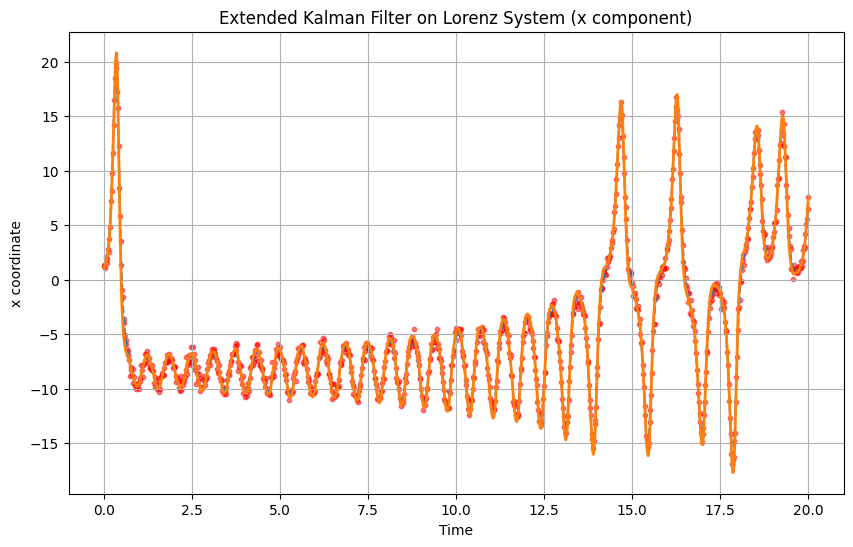

In [7]:
import numpy as np
import scipy.linalg
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ----------------------------------------------------------------
# Lorenz System Parameters
# ----------------------------------------------------------------
sigma = 10.0
rho   = 28.0
beta  = 8/3

# ----------------------------------------------------------------
# Lorenz System Dynamics and Jacobian
# ----------------------------------------------------------------
def lorenz_system(x):
    """
    Computes the Lorenz system derivatives at state x.
    x: 1D numpy array of shape (3,) representing [x, y, z]
    Returns a 1D array [dx/dt, dy/dt, dz/dt]
    """
    return np.array([
        sigma * (x[1] - x[0]),
        x[0]*(rho - x[2]) - x[1],
        x[0]*x[1] - beta * x[2]
    ])

def lorenz_jacobian(x):
    """
    Computes the 3x3 Jacobian matrix of the Lorenz system at state x.
    x: 1D array of shape (3,)
    Returns a 3x3 numpy array.
    """
    return np.array([
        [-sigma,      sigma,       0],
        [rho - x[2],  -1,         -x[0]],
        [x[1],        x[0],      -beta]
    ])

# ----------------------------------------------------------------
# Data Generation
# ----------------------------------------------------------------
def generate_lorenz_data(dt=0.02, t_end=20.0, x0=[1.0, 1.0, 1.0], R_val=0.2, seed=42):
    """
    Generates a Lorenz trajectory by numerically integrating the Lorenz ODE,
    then adds measurement noise for observations of (x, y).

    Returns:
      time_span: 1D array of time points.
      x_true:      (N, 3) array of true states [x, y, z].
      measurements: (N, 2) array of noisy measurements of [x, y].
      R:           Measurement noise covariance (2x2 matrix).
    """
    np.random.seed(seed)
    
    N = int(round(t_end/dt))
    time_span = np.linspace(0, t_end, N)
    
    # Define the ODE function (Lorenz system)
    def lorenz_ode(t, x):
        return lorenz_system(x)
    
    sol = solve_ivp(lorenz_ode, [0, t_end], x0, t_eval=time_span)
    x_true = sol.y.T  # shape (N, 3)
    
    # Measurement noise covariance for (x,y) measurements.
    R = np.eye(2) * R_val
    noise = np.random.normal(0, 1, (N, 2)) @ scipy.linalg.sqrtm(R).T
    measurements = x_true[:, :2] + noise
    
    return time_span, x_true, measurements, R

# ----------------------------------------------------------------
# Extended Kalman Filter Functions for Lorenz
# ----------------------------------------------------------------
def ekf_predict(x_est, P_est, dt, Q):
    """
    EKF predict step.
    x_est: current state estimate (3,) array.
    P_est: current state covariance (3x3).
    dt: time step.
    Q: process noise covariance (3x3).
    
    Returns:
      x_pred: predicted state estimate.
      P_pred: predicted state covariance.
    """
    # Propagate state using Euler (you can also use a more accurate integration if desired)
    f = lorenz_system(x_est)
    x_pred = x_est + f * dt
    
    # Linearize: compute Jacobian at current state and discretize.
    J = lorenz_jacobian(x_est)
    A = scipy.linalg.expm(J * dt)
    P_pred = A @ P_est @ A.T + Q
    
    return x_pred, P_pred

def ekf_update(x_pred, P_pred, y, R):
    """
    EKF update step using 2D measurements.
    y: measurement vector (2,) corresponding to observed [x, y].
    R: measurement noise covariance (2x2).
    
    Returns:
      x_upd: updated state estimate.
      P_upd: updated state covariance.
    """
    # Measurement matrix: we measure the first two coordinates
    H = np.array([[1, 0, 0],
                  [0, 1, 0]])
    innovation = y - (H @ x_pred)
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    
    x_upd = x_pred + K @ innovation
    P_upd = (np.eye(3) - K @ H) @ P_pred
    return x_upd, P_upd

def run_ekf_lorenz(time_span, x_true, measurements, dt, Q, R, x0_est, P0):
    """
    Runs the extended Kalman filter on Lorenz data.
    time_span: 1D array of time points.
    x_true: (N,3) true states.
    measurements: (N,2) noisy measurements.
    dt: time step.
    Q: process noise covariance (3x3).
    R: measurement noise covariance (2x2).
    x0_est: initial state estimate (3,).
    P0: initial covariance (3x3).
    
    Returns:
      x_est_array: (N,3) array of filtered state estimates.
    """
    N = len(time_span)
    x_est_array = np.zeros((N, 3))
    x_est = x0_est.copy()
    P_est = P0.copy()
    
    for k in range(N):
        # Predict step
        x_pred, P_pred = ekf_predict(x_est, P_est, dt, Q)
        # Update step with measurement at time k
        y = measurements[k]  # shape (2,)
        x_est, P_est = ekf_update(x_pred, P_pred, y, R)
        x_est_array[k] = x_est
    return x_est_array

# ----------------------------------------------------------------
# Main script
# ----------------------------------------------------------------
def main():
    # Simulation parameters
    dt = 0.02
    t_end = 20.0
    x0 = [1.0, 1.0, 1.0]  # True initial condition
    R_val = 0.2          # Measurement noise variance
    Q_val = 0.01         # Process noise scale
    
    # Process noise covariance for 3D state
    Q = np.eye(3) * Q_val
    
    # Generate true Lorenz data and measurements
    time_span, x_true, measurements, R = generate_lorenz_data(dt=dt, t_end=t_end, x0=x0, R_val=R_val, seed=42)
    
    # Initial EKF estimate (we might start at the true value if known, or with some error)
    x0_est = np.array([1.0, 1.0, 1.0])
    P0 = np.eye(3)  # Initial uncertainty
    
    # Run EKF on the Lorenz data
    x_est_array = run_ekf_lorenz(time_span, x_true, measurements, dt, Q, R, x0_est, P0)
    
    # Plot the first coordinate (x) over time:
    plt.figure(figsize=(10,6))
    plt.plot(time_span, x_true[:,0], label='True x', linestyle='--')
    plt.plot(time_span, x_est_array[:,0], label='Filtered x', linewidth=2)
    plt.scatter(time_span, measurements[:,0], label='Measured x', color='red', s=10, alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel('x coordinate')
    plt.title('Extended Kalman Filter on Lorenz System (x component)')
    # plt.legend()
    plt.grid(True)
    plt.show()
    
if __name__ == "__main__":
    main()


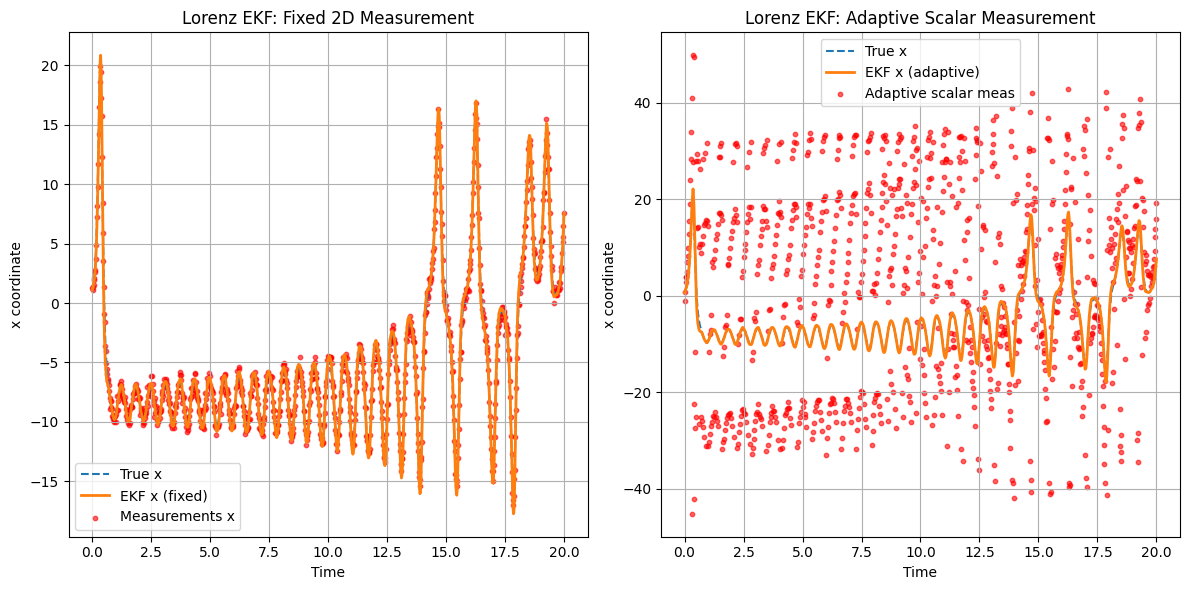

In [8]:
import numpy as np
import scipy.linalg
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ====================================================
# Lorenz System Dynamics and Jacobian
# ====================================================
sigma = 10.0
rho   = 28.0
beta  = 8/3

def lorenz_system(x):
    """Lorenz system derivatives at state x = [x, y, z]."""
    return np.array([
        sigma * (x[1] - x[0]),
        x[0]*(rho - x[2]) - x[1],
        x[0]*x[1] - beta*x[2]
    ])

def lorenz_jacobian(x):
    """3x3 Jacobian of the Lorenz system at state x."""
    return np.array([
        [-sigma,      sigma,       0],
        [rho - x[2],  -1,         -x[0]],
        [x[1],        x[0],      -beta]
    ])

# ====================================================
# Data Generation for Lorenz (Fixed Measurement Data)
# ====================================================
def generate_lorenz_data(dt=0.02, t_end=20.0, x0=[1.0, 1.0, 1.0], R_val=0.2, seed=42):
    """
    Integrates the Lorenz ODE and generates noisy measurements of (x,y).

    Returns:
      time_span: 1D array of time points.
      x_true:      (N,3) array of true states.
      measurements: (N,2) array of noisy observations of [x, y].
      R:           Measurement noise covariance (2x2).
    """
    np.random.seed(seed)
    N = int(round(t_end/dt))
    time_span = np.linspace(0, t_end, N)
    
    def lorenz_ode(t, x):
        return lorenz_system(x)
    
    sol = solve_ivp(lorenz_ode, [0, t_end], x0, t_eval=time_span)
    x_true = sol.y.T  # shape (N,3)
    
    R = np.eye(2) * R_val
    noise = np.random.normal(0, 1, (N, 2)) @ scipy.linalg.sqrtm(R).T
    measurements = x_true[:, :2] + noise
    return time_span, x_true, measurements, R

# ====================================================
# EKF Functions (Common Predict Step)
# ====================================================
def ekf_predict(x_est, P_est, dt, Q):
    """
    EKF predict step:
      x_pred = x_est + f(x_est)*dt   (Euler integration)
      P_pred = A * P_est * A.T + Q, where A = expm(J*dt) with J = jacobian at x_est.
    """
    f = lorenz_system(x_est)
    x_pred = x_est + f * dt
    J = lorenz_jacobian(x_est)
    A = scipy.linalg.expm(J * dt)
    P_pred = A @ P_est @ A.T + Q
    return x_pred, P_pred

# ====================================================
# Fixed Measurement Update (2D)
# ====================================================
def ekf_update_fixed(x_pred, P_pred, y, R):
    """
    EKF update step for fixed 2D measurements:
      H = [[1,0,0],[0,1,0]].
    """
    H = np.array([[1,0,0],
                  [0,1,0]])
    innovation = y - (H @ x_pred)
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x_upd = x_pred + K @ innovation
    P_upd = (np.eye(3) - K @ H) @ P_pred
    return x_upd, P_upd

def run_ekf_lorenz_fixed(time_span, x_true, measurements, dt, Q, R, x0_est, P0):
    """
    Runs an EKF on Lorenz data using fixed 2D measurements.
    """
    N = len(time_span)
    x_est_array = np.zeros((N, 3))
    x_est = x0_est.copy()
    P_est = P0.copy()
    
    for k in range(N):
        x_pred, P_pred = ekf_predict(x_est, P_est, dt, Q)
        y = measurements[k]  # 2D measurement [x, y]
        x_est, P_est = ekf_update_fixed(x_pred, P_pred, y, R)
        x_est_array[k] = x_est
    return x_est_array

# ====================================================
# Adaptive Measurement Update (Scalar)
# ====================================================
def kalman_update_scalar(x_pred, P_pred, y, m, R_scalar):
    """
    EKF update for a scalar measurement:
      y = m^T x + noise, where m is a 3D unit vector.
    """
    y_pred = m @ x_pred
    innovation = y - y_pred
    S = m @ P_pred @ m + R_scalar  # scalar
    K = (P_pred @ m) / S
    x_upd = x_pred + K * innovation
    P_upd = P_pred - np.outer(K, m) @ P_pred
    return x_upd, P_upd

def principal_eigenvector(P):
    """Returns the principal eigenvector of a matrix P (in 3D) normalized to unit length."""
    vals, vecs = np.linalg.eig(P)
    idx = np.argmax(vals)
    v = vecs[:, idx]
    return v / np.linalg.norm(v)

def run_ekf_lorenz_adaptive(time_span, x_true, dt, Q, R_scalar, x0_est, P0, seed=42):
    """
    Runs an EKF on Lorenz data with an adaptive measurement model:
    At each step, choose m = principal eigenvector of P_pred and measure a scalar:
      y = m^T x_true + noise,  noise ~ N(0, R_scalar).
      
    Note: The measurement model here is different from the fixed 2D measurement.
    """
    np.random.seed(seed)
    N = len(time_span)
    x_est_array = np.zeros((N, 3))
    measurements_adapt = np.zeros(N)
    
    x_est = x0_est.copy()
    P_est = P0.copy()
    
    for k in range(N):
        x_pred, P_pred = ekf_predict(x_est, P_est, dt, Q)
        # Adaptive measurement direction: principal eigenvector of P_pred
        m = principal_eigenvector(P_pred)
        # Generate scalar measurement from true state using m:
        noise = np.random.normal(0, np.sqrt(R_scalar))
        y = m @ x_true[k] + noise
        # Update using scalar measurement update
        x_est, P_est = kalman_update_scalar(x_pred, P_pred, y, m, R_scalar)
        x_est_array[k] = x_est
        measurements_adapt[k] = y
    return x_est_array, measurements_adapt

# ====================================================
# Main Script: Run Both Filters and Compare
# ====================================================
def main():
    # Simulation parameters
    dt = 0.02
    t_end = 20.0
    x0 = [1.0, 1.0, 1.0]
    R_val = 0.2   # For fixed 2D measurement (used in R matrix)
    R_scalar = 0.2  # For adaptive (scalar) measurement
    Q_val = 0.01  # Process noise scale
    
    Q = np.eye(3) * Q_val  # 3D process noise covariance
    
    # Generate Lorenz data with fixed 2D measurements (for comparison)
    time_span, x_true, measurements_fixed, R_fixed = generate_lorenz_data(dt=dt, t_end=t_end, x0=x0, R_val=R_val, seed=42)
    
    # Initial EKF estimate and covariance
    x0_est = np.array([1.0, 1.0, 1.0])
    P0 = np.eye(3)
    
    # Run EKF with fixed 2D measurement update
    x_est_fixed = run_ekf_lorenz_fixed(time_span, x_true, measurements_fixed, dt, Q, R_fixed, x0_est, P0)
    
    # Run EKF with adaptive scalar measurement update
    # Note: For adaptive measurement, we generate scalar measurements on the fly.
    x_est_adapt, meas_adapt = run_ekf_lorenz_adaptive(time_span, x_true, dt, Q, R_scalar, x0_est, P0, seed=42)
    
    # Plot: Compare the x coordinate estimates (first state component)
    plt.figure(figsize=(12,6))
    
    # Fixed measurement plot
    plt.subplot(1,2,1)
    plt.plot(time_span, x_true[:,0], label='True x', linestyle='--')
    plt.plot(time_span, x_est_fixed[:,0], label='EKF x (fixed)', linewidth=2)
    plt.scatter(time_span, measurements_fixed[:,0], s=10, color='red', alpha=0.6, label='Measurements x')
    plt.title('Lorenz EKF: Fixed 2D Measurement')
    plt.xlabel('Time')
    plt.ylabel('x coordinate')
    plt.legend()
    plt.grid(True)
    
    # Adaptive measurement plot
    plt.subplot(1,2,2)
    plt.plot(time_span, x_true[:,0], label='True x', linestyle='--')
    plt.plot(time_span, x_est_adapt[:,0], label='EKF x (adaptive)', linewidth=2)
    plt.scatter(time_span, meas_adapt, s=10, color='red', alpha=0.6, label='Adaptive scalar meas')
    plt.title('Lorenz EKF: Adaptive Scalar Measurement')
    plt.xlabel('Time')
    plt.ylabel('x coordinate')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
